In [1]:
import utils
import fevd
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import statsmodels.api as sm
from scipy.stats import norm
from numba import njit, prange
from tqdm import tqdm
from copy import deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
# Settings
from_web = False # Should data be downloaded again?
max_h = 21 # Maximum horizon
pp = 2 # Number of lags
prob = 0.05 # Significance level
cov_type = 'DC' # Covariance estimator
trend_filter = 'Trend' # Filtering method
do_truth = True # If the truth should be estimated when computing the FEVD
Nb = 500 # Number of bootstrap replications
Nt = 10 # Number of bootstrap replications when computing the truth
true_fact = 10 # How much to multiply sample size with when computing the truth in the bootstrap
alpha = 0.1 # 2*quantile for FEVD in MATLAB

### Effect on large economy

In [3]:
# Create data set
var_mask = ['Y','P','R','RR','PI','IM']
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask, Ys=['Y','P','R','RR'], quiet=False)

- FULL DATA INFO -
Number of countries: 39
Number of columns: 235
Sample size: 11388
Average sample size per country: 292
Max lag: 22
Effective sample start: 1947-01-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 
 - Y DATA INFO - 
Number of countries: 32
Number of columns: 3
Sample size: 3795
Average sample size per country: 119
Effective sample start: 1961-01-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 


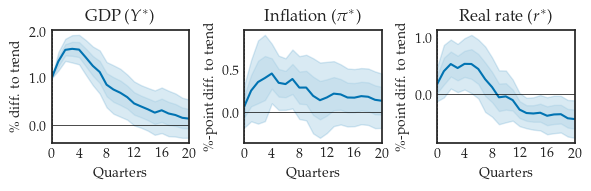

In [4]:
# Compute and plot IRFs
controls = {'Y_star': ['Y_star']}
dep_vars = {
    'Y_star': 'GDP ($Y^*$)',
    'P_star': 'Inflation ($\pi^*$)',
    'RR_star': 'Real rate ($r^*$)'
}
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type, TFE=False)
utils.plot_irfs(IRF, SE, dep_vars, prob, max_cols=4, save='Figures/fig_LP_large.pdf')

### Main IRFs

In [5]:
# Create panel data set
var_mask = ['Y','C','I','EX','IM','NX','E','R','RR','YT','YNT','CT','CNT','P','PI']
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask, Ys=['Y'])

- FULL DATA INFO -
Number of countries: 39
Number of columns: 373
Sample size: 11388
Average sample size per country: 292
Max lag: 22
Effective sample start: 1947-01-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 
 - Y DATA INFO - 
Number of countries: 32
Number of columns: 3
Sample size: 3795
Average sample size per country: 119
Effective sample start: 1961-01-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 


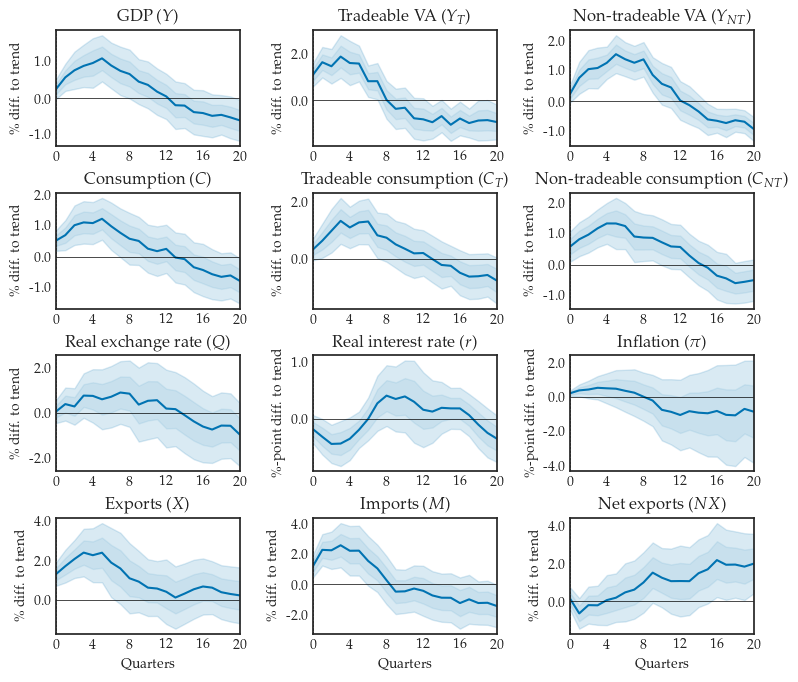

In [6]:
# Compute and plot IRFs
controls = {}
dep_vars = {
    'Y': 'GDP ($Y$)',
    'YT': 'Tradeable VA ($Y_T$)',
    'YNT': 'Non-tradeable VA ($Y_{NT}$)',
    'C': 'Consumption ($C$)',
    'CT': 'Tradeable consumption ($C_T$)',
    'CNT': 'Non-tradeable consumption ($C_{NT}$)',
    'E': 'Real exchange rate ($Q$)',
    'RR': 'Real interest rate ($r$)',
    'P': 'Inflation ($\pi$)',
    'EX': 'Exports ($X$)',
    'IM': 'Imports ($M$)',
    'NX': 'Net exports ($NX$)'
}
full_dep_vars = dep_vars
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP.pdf')
beta0 = RES['Y_0'].params[-1]

### Save data for MATLAB

In [7]:
utils.save_for_matlab(pp=4, trend_filter=trend_filter)

### Only big economies on RHS

- FULL DATA INFO -
Number of countries: 39
Number of columns: 373
Sample size: 11388
Average sample size per country: 292
Max lag: 22
Effective sample start: 1947-01-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 
 - Y DATA INFO - 
Number of countries: 32
Number of columns: 3
Sample size: 3795
Average sample size per country: 119
Effective sample start: 1961-01-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 


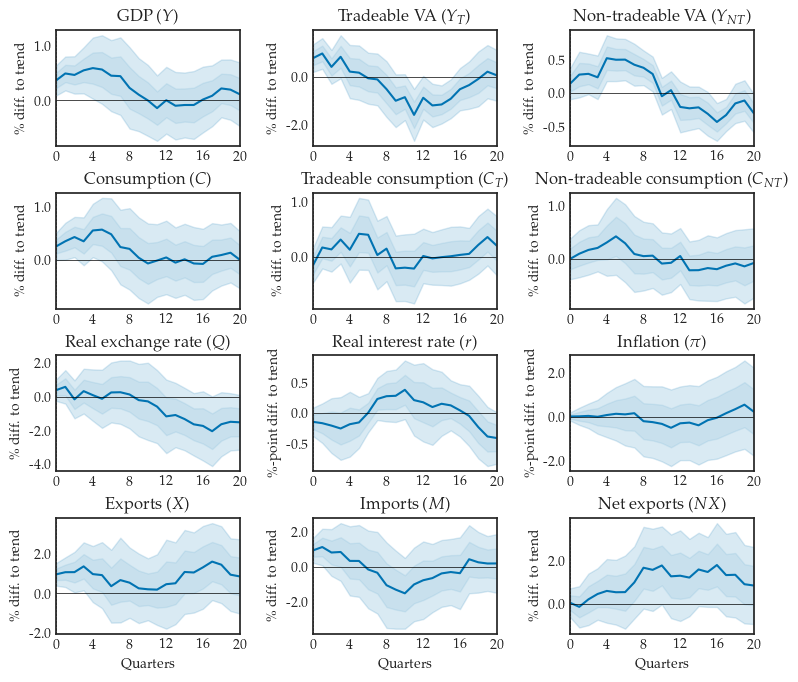

In [8]:
# Compute and plot IRFs
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask, Ys=['Y'], only_big=True)
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_large_only.pdf')

### Common weights

- FULL DATA INFO -
Number of countries: 39
Number of columns: 373
Sample size: 11388
Average sample size per country: 292
Max lag: 22
Effective sample start: 1947-01-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 
 - Y DATA INFO - 
Number of countries: 32
Number of columns: 3
Sample size: 3795
Average sample size per country: 119
Effective sample start: 1961-01-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 


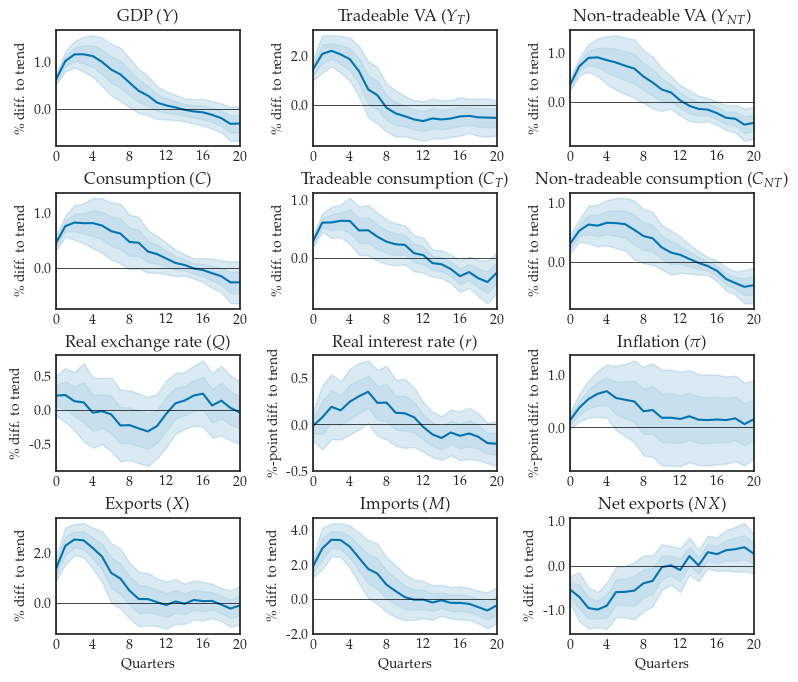

In [9]:
# Compute and plot IRFs
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask, Ys=['Y'], common_weights=True)
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type, TFE=False)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_common_weights.pdf')

### Multipliers

In [10]:
# Create panel data set
var_mask = ['Y','C','I','EX','IM','NX','YT','YNT','CT','CNT']
df = utils.create_reg_data(max_h, pp, trend_filter=trend_filter, var_mask=var_mask, h=8, Ys=['Y'], quiet=True)

In [11]:
# Multipliers
sign = norm.ppf(1-prob/2)
dep_vars = var_mask
for var in dep_vars:
    controls = ['Y_star', var]
    depvar = f'{var}cum'
    res, _ = utils.lp_reg(df=df, control_vars=controls, pp=pp, cov_type=cov_type, depvar=depvar, cum=True)
    
    b = res.params[-1]
    se = res.bse[-1]
    lo = b - sign*se
    hi = b + sign*se
    
    varstr = f'{var}:'
    print(f'{varstr:3} {b:.2f} ({lo:.2f}, {hi:.2f})')

Y:  0.85 (0.40, 1.30)
C:  0.78 (0.27, 1.29)
I:  2.49 (0.83, 4.15)
EX: 2.51 (1.78, 3.23)
IM: 1.81 (0.91, 2.72)
NX: 0.61 (-0.24, 1.46)
YT: 1.11 (0.61, 1.62)
YNT: 0.74 (0.31, 1.17)
CT: 0.80 (0.31, 1.30)
CNT: 0.91 (0.33, 1.49)


### Country-specific betas

In [12]:
# Create panel data set
var_mask = ['Y','C','I','EX','IM','NX']
df = utils.create_reg_data(max_h, pp, trend_filter=trend_filter, var_mask=var_mask, Ys=['Y'], years=False, quiet=True,
                           add_interactions=True)

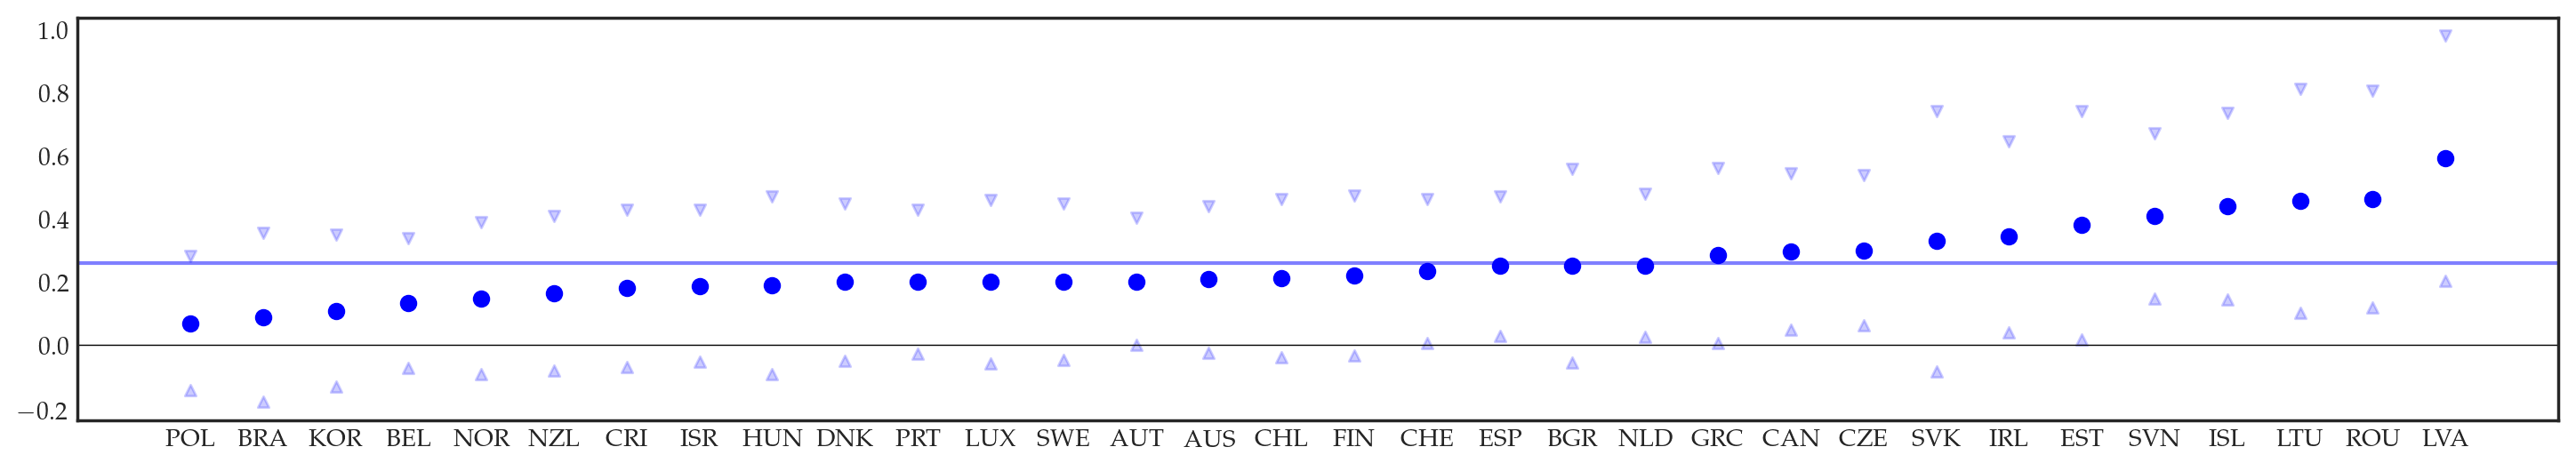

In [13]:
# Regression
depvar = 'Y'
controls = ['Y_star', depvar]
res, comps = utils.lp_reg(df, controls, pp=pp, cov_type=cov_type, depvar=depvar,
                          h=0, TFE=True, mode='contemp', country_dummies=True, all_countries=True)

# Compute betas
countries = [res.model.exog_names[-i].split('_')[-1] for i in range(32,0,-1)]
df_betas = pd.DataFrame(index=countries, columns=['beta','lo','hi','country'], dtype=np.float64)
for i in range(32, 0, -1):
    country = res.model.exog_names[-i].split('_')[-1]
    df_betas.loc[country,'beta'] = res.params[-i]
    df_betas.loc[country,'lo'] = res.params[-i] - 1.96*res.bse[-i]
    df_betas.loc[country,'hi'] = res.params[-i] + 1.96*res.bse[-i]
df_betas['country'] = countries
df_betas = df_betas.sort_values(by='beta')

# Do plot
plt.figure(figsize=(18,3), dpi=200)
plt.scatter(df_betas['country'], df_betas['beta'], color='blue')
plt.scatter(df_betas['country'], df_betas['lo'], marker='^', s=20, color='blue', alpha=.2)
plt.scatter(df_betas['country'], df_betas['hi'], marker='v', s=20, color='blue', alpha=.2)
plt.axhline(beta0, color='blue', alpha=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.savefig('Figures/fig_LP_countries.pdf', bbox_inches='tight')

### Floating countries only

- FULL DATA INFO -
Number of countries: 33
Number of columns: 374
Sample size: 4229
Average sample size per country: 128
Max lag: 22
Effective sample start: 1947-01-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 
 - Y DATA INFO - 
Number of countries: 19
Number of columns: 3
Sample size: 1515
Average sample size per country: 80
Effective sample start: 1964-04-01 00:00:00
Effective sample end: 2019-10-01 00:00:00
 


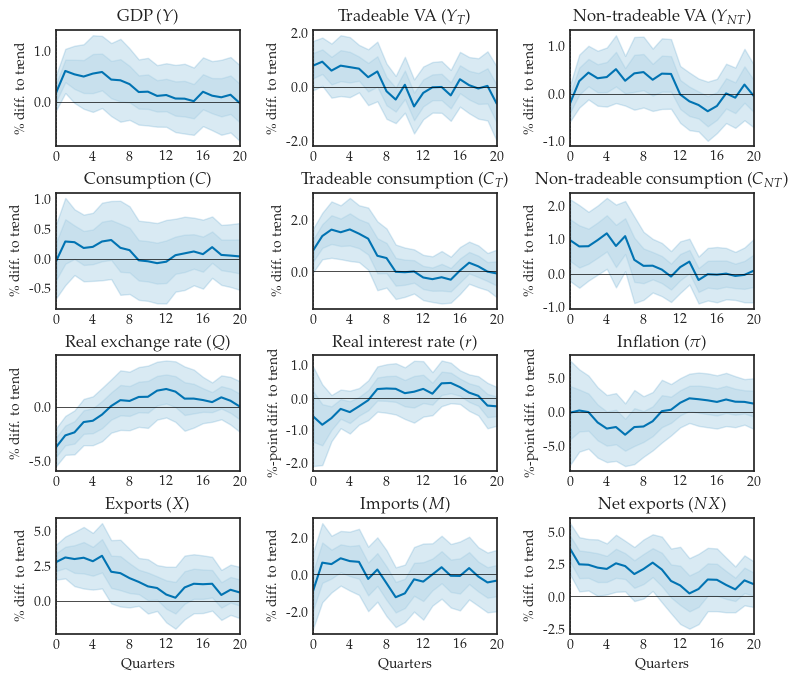

In [14]:
var_mask = ['Y','C','I','EX','IM','NX','E','R','RR','YT','YNT','CT','CNT','P','PI']
dep_vars = full_dep_vars
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask, Ys=['Y'], regime='Floating')
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_floating.pdf')

### Fixed countries only

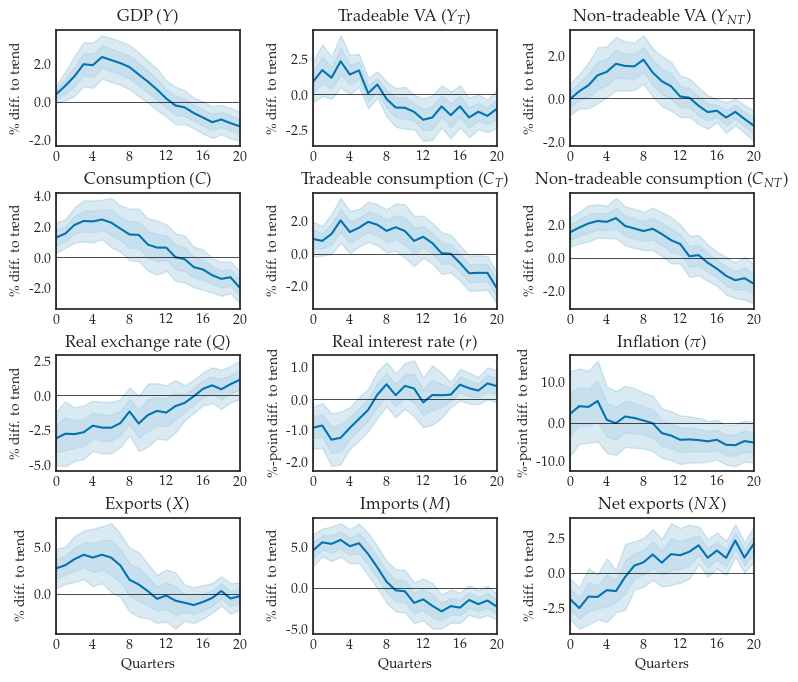

In [15]:
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask, Ys=['Y'], regime='Fixed', quiet=True)
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_fixed.pdf')

### Investment response

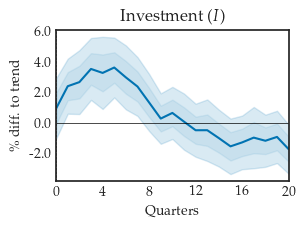

In [16]:
# Create panel data set
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask=var_mask, Ys=['Y'], quiet=True)

# Compute and plot IRFs
IRF, SE, RES = utils.compute_irfs(df, {'I': 'Investment ($I$)'}, controls, max_h, pp, cov_type=cov_type)
utils.plot_irfs(IRF, SE, {'I': 'Investment ($I$)'}, prob, save='Figures/fig_LP_I.pdf')

### Balanced panel w/o weird exchange rate periods

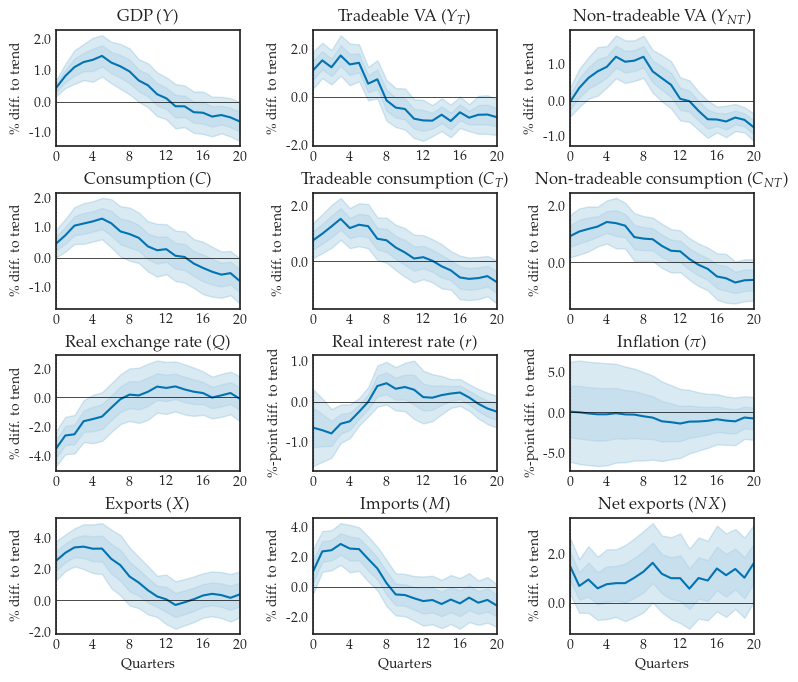

In [17]:
# Create panel data set
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask=var_mask, Ys=['Y'], quiet=True)
df = df.loc['1996':]

# Compute and plot IRFs
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_wo_BW.pdf')

### Import shock

In [18]:
# Create panel data set
var_mask = ['Y','C','I','EX','IM','NX','E','R','RR','YT','YNT','CT','CNT','P','PI']
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask, Ys=['IM','Y'], quiet=True)
df = df.drop('Y_star', axis=1)
df = df.rename(columns={'IM_star': 'Y_star'})
for i in range(1,max_h+pp):
    df = df.drop(f'Y_{i}_star', axis=1)
    df = df.rename(columns={f'IM_{i}_star': f'Y_{i}_star'})

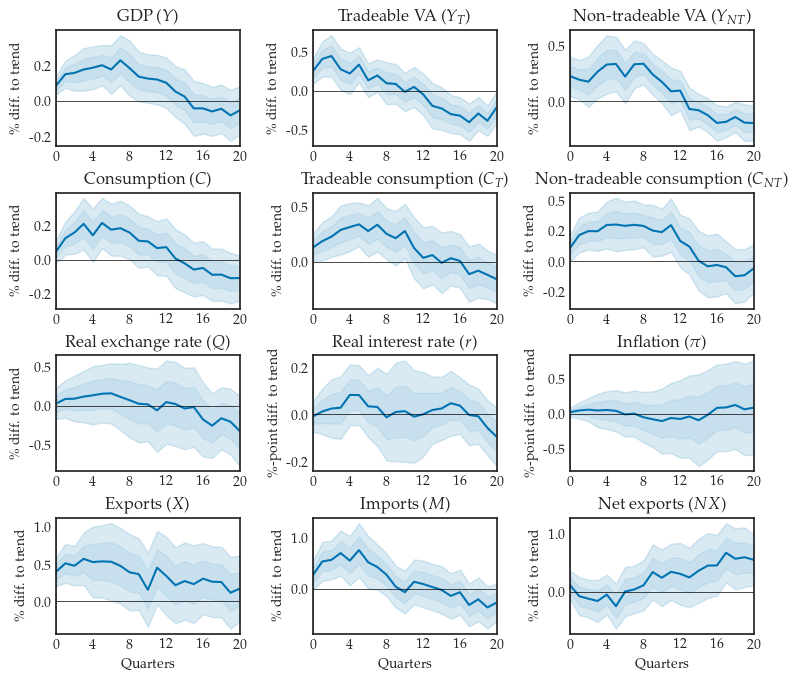

In [19]:
# Compute and plot IRFs
controls = {}
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_IM.pdf')

### No time FE

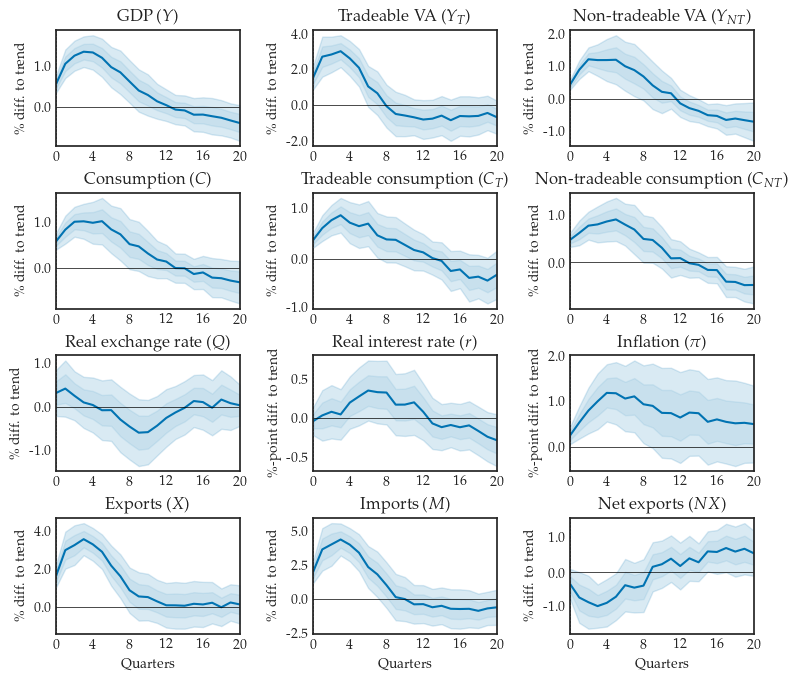

In [20]:
# Create panel data set
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask, Ys=['Y'], quiet=True)

# Compute and plot IRFs
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type, TFE=False)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_wo_FE.pdf')

### Time $\times$ region fixed effects

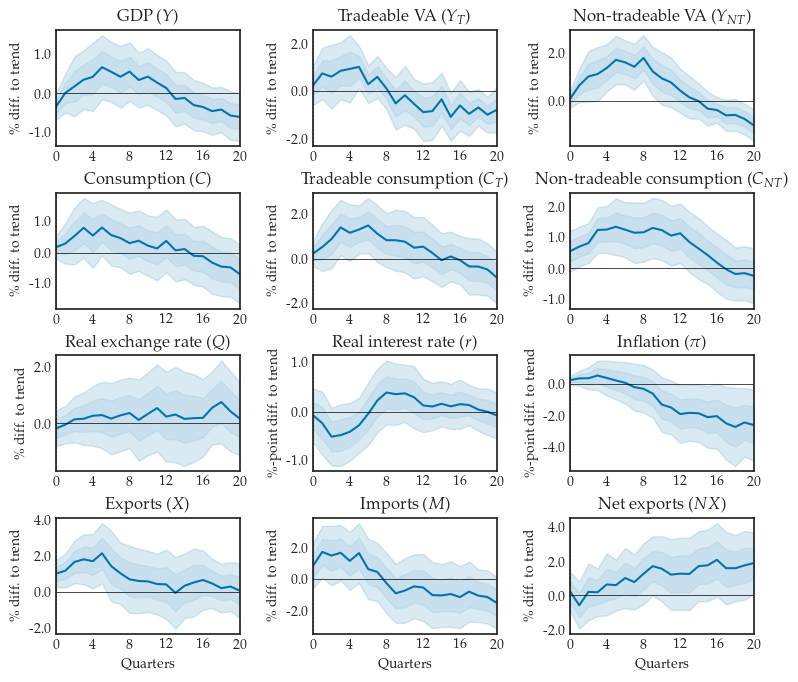

In [21]:
# Create panel data set
df = utils.create_reg_data(max_h, pp, trend_filter, var_mask, Ys=['Y'], regions=True, quiet=True)

# Compute and plot IRFs
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type,
                                  regions=['Adv','Em','G20','EA','Am','As','Eu'])
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_TFE.pdf')

### HP filter

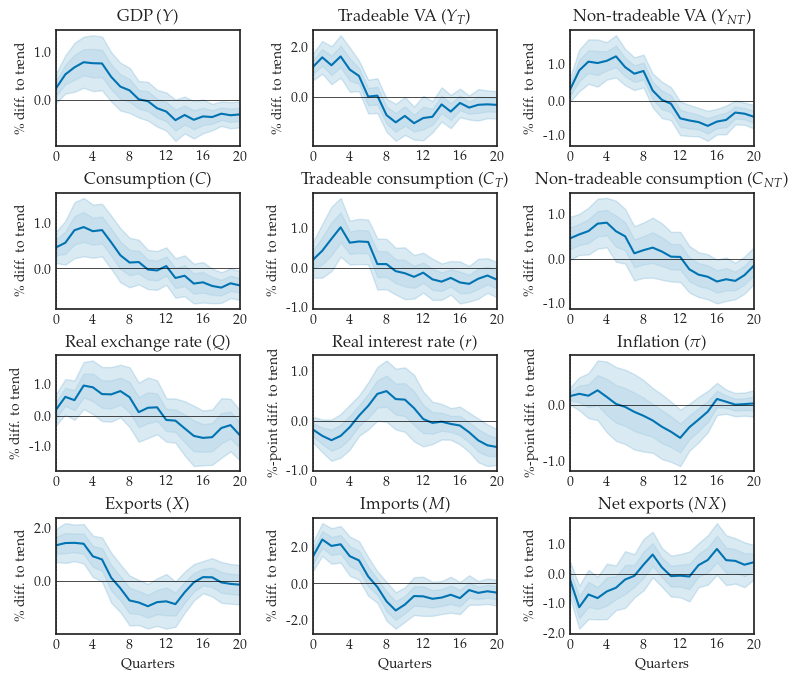

In [22]:
# Create panel data set
df = utils.create_reg_data(max_h, pp, trend_filter='HP', var_mask=var_mask, Ys=['Y'], quiet=True)

# Compute and plot IRFs
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_HP.pdf')

### Hamilton filter

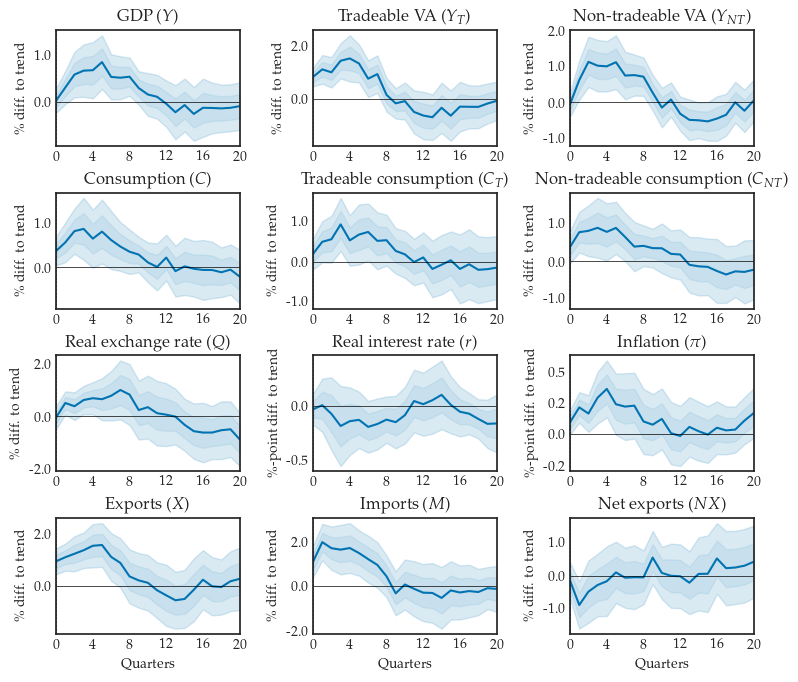

In [23]:
# Create panel data set
df = utils.create_reg_data(max_h, pp, trend_filter='Hamilton', var_mask=var_mask, Ys=['Y'], quiet=True)

# Compute and plot IRFs
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp, cov_type=cov_type)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_Hamilton.pdf')

### 4 lags

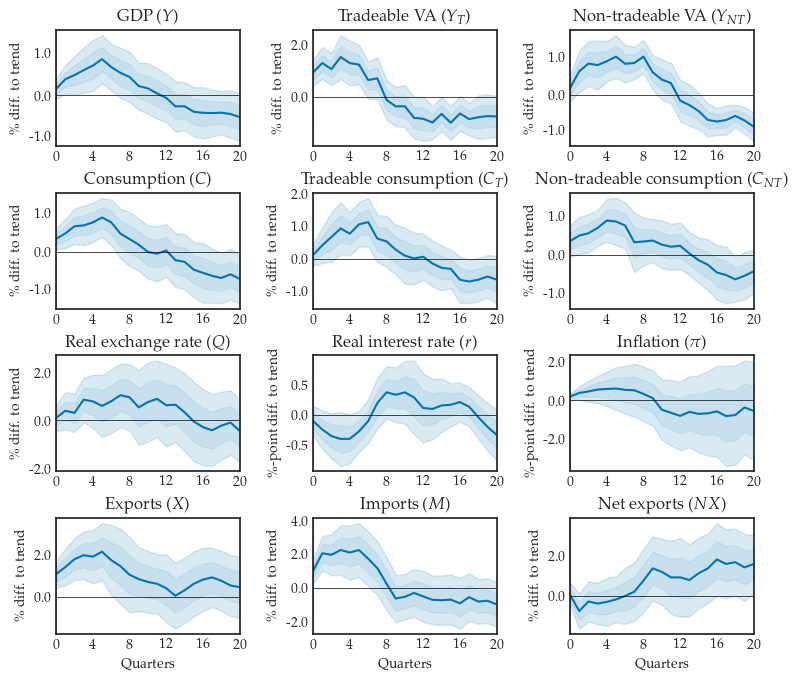

In [24]:
# Create panel data set
df = utils.create_reg_data(max_h, pp=4, trend_filter=trend_filter, var_mask=var_mask, Ys=['Y'], quiet=True)

# Compute and plot IRFs
IRF, SE, RES = utils.compute_irfs(df, dep_vars, controls, max_h, pp=4, cov_type=cov_type)
utils.plot_irfs(IRF, SE, dep_vars, prob, save='Figures/fig_LP_4.pdf')

### Show countries in the sample

In [25]:
df = pd.read_pickle('Data/oecd_large.pkl')
df = df.dropna(axis=1, how='all')
countries = set([col.split('_')[1] for col in df])
large_countries = {'USA','CHN','JPN','DEU','GBR','IND','FRA','ITA'}.intersection(countries)
small_countries = countries.difference(large_countries)
print(f'Large: {sorted(large_countries)} ({len(large_countries)})')
print(f'Small: {sorted(small_countries)} ({len(small_countries)})')

Large: ['DEU', 'FRA', 'GBR', 'IND', 'ITA', 'JPN', 'USA'] (7)
Small: ['ARG', 'AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHL', 'COL', 'CRI', 'CZE', 'DNK', 'ESP', 'EST', 'FIN', 'GRC', 'HUN', 'IDN', 'IRL', 'ISL', 'ISR', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'NZL', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'ZAF'] (39)


### FEVD

In [26]:
np.random.seed(1)
outs = {}
hs = [4,8,40]
for depvar in ['Y','C','EX','IM','NX']:
    print(depvar)
    out = fevd.bootstrap_FEVD(depvar=depvar, hs=hs, pp_VD=pp, pp=pp, prob=prob,
                              trend_filter=trend_filter, TFE=True, do_truth=do_truth, true_fact=true_fact,
                              Nt=Nt, Nb=Nb)
    outs[depvar] = out

Y


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [43:57<00:00,  5.27s/it]


C


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [45:58<00:00,  5.52s/it]


EX


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [45:40<00:00,  5.48s/it]


IM


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [44:19<00:00,  5.32s/it]


NX


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [44:05<00:00,  5.29s/it]


In [27]:
for var in ['Y','C','EX','IM','NX']:
    print(f'{var}:')
    print(outs[var][['Corr','Corr_lo','Corr_hi']].round(1))
    print('\n')

Y:
    Corr  Corr_lo  Corr_hi
4   21.7     19.8     24.0
8   27.9     24.9     30.9
40  19.4     15.2     23.2


C:
    Corr  Corr_lo  Corr_hi
4   21.8     20.4     23.4
8   26.4     24.6     28.5
40  17.4     13.7     19.9


EX:
    Corr  Corr_lo  Corr_hi
4   16.0     14.4     18.1
8   20.3     18.0     22.9
40  15.5     10.9     19.1


IM:
    Corr  Corr_lo  Corr_hi
4   15.0     12.7     17.4
8   19.6     16.6     22.7
40  18.3     14.0     22.4


NX:
    Corr  Corr_lo  Corr_hi
4   14.5     12.6     16.6
8   19.9     17.5     22.6
40   9.2      4.6     13.1




### $R^2$ example

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     36.81
Date:                Tue, 11 Oct 2022   Prob (F-statistic):           2.58e-09
Time:                        20:21:07   Log-Likelihood:                -1008.0
No. Observations:                 500   AIC:                             2020.
Df Residuals:                     498   BIC:                             2028.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6964      0.081      8.554      0.000       0.536       0.856
x1             0.4973      0.082      6.067      0.000       0.336       0.658
==============================================================================
Omnibus:                      133.150   Durbin-Watson:                   0.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.908
Skew:                          -0.502   Prob(JB):                     4.82e-10
Kurtosis:                       1.974   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

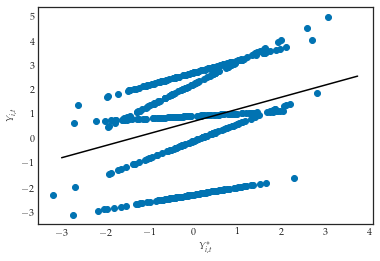

In [28]:
np.random.seed(1000)
alphas = np.random.uniform(-3,3,size=5)
betas = [0.1, 0.3, 0.5, 0.7, 0.9]
Y_star = np.random.normal(size=(5, 100))
Y = np.full((5, 100), np.nan)
for i in range(5):
    Y[i,:] = alphas[i] + betas[i]*Y_star[i,:]
Y = Y.flatten().reshape(-1,1)
X = Y_star.flatten().reshape(-1,1)
X = np.concatenate([np.ones((500,1)), X], axis=1)
plt.scatter(X[:,1], Y)
plt.xlabel('$Y_{i,t}^*$')
plt.ylabel('$Y_{i,t}$')
beta_hat = (np.linalg.inv(X.T@X)@X.T@Y)[0,0]
res = sm.OLS(Y,X).fit()
X = np.arange(-3,3.75,0.01)
plt.plot(X, res.params[0] + res.params[1]*X, color='black')
plt.savefig('Figures/fig_R2.pdf', bbox_inches='tight')
res.summary()

### MATLAB: IRFs

In [29]:
max_h -= 1

def scale_and_quantile(Ltilde, prob):
    Ltilde = np.quantile(Ltilde, q=[prob/2, 0.5, 1-prob/2], axis=3) # Quantile, horizon, varno, shockno
    scale = 1/Ltilde[1,0,1,1]
    Ltilde = scale*Ltilde[:,:max_h,0,1].reshape(3,max_h) # quantiles, max_h
    return Ltilde

IRF = np.full((len(dep_vars),6,20), np.nan)
for i, var in enumerate(dep_vars):
    Ltilde = sio.loadmat(f'Data/MATLAB/Ltilde_{var}.mat')['Ltilde'] # Horizon, varno, shockno, draws
    Ltilde95 = scale_and_quantile(Ltilde, 0.05)
    Ltilde68 = scale_and_quantile(Ltilde, 0.32)
    
    IRF[i,:3,:] = Ltilde95
    IRF[i,3:,:] = Ltilde68

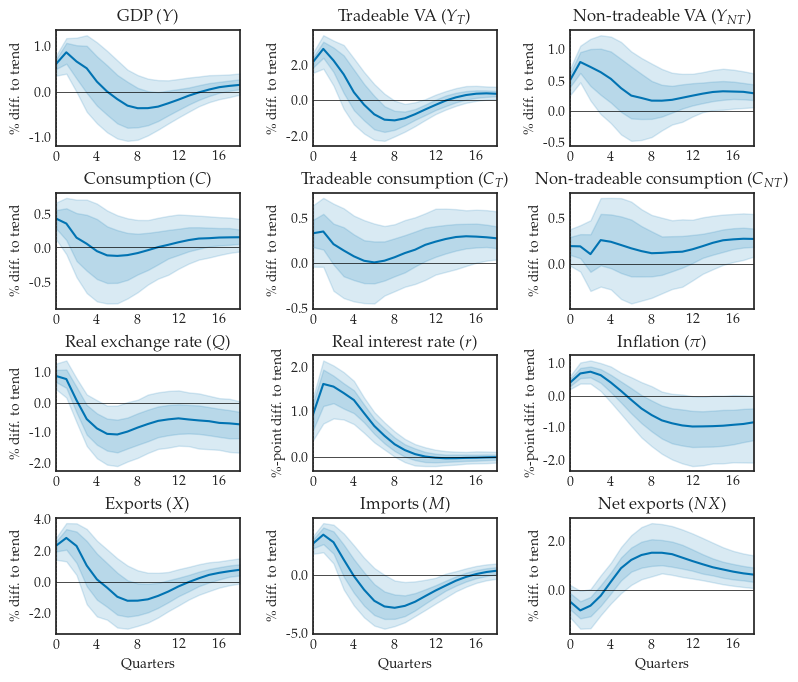

In [30]:
utils.plot_irfs(IRF[:,1,:], None, dep_vars, LO=IRF[:,[0,3],:], HI=IRF[:,[2,5],:], save='Figures/fig_SVAR.pdf')

### MATLAB: FEVD

In [31]:
for var in ['Y','C','EX','IM','NX']:
    FEVDs = sio.loadmat(f'Data/MATLAB/FEVDs_{var}.mat')['FEVDs'][:,[4,8,39]]
    FEVD = np.mean(FEVDs, axis=0)
    FEVD_LO = np.quantile(FEVDs, axis=0, q=alpha/2)
    FEVD_HI = np.quantile(FEVDs, axis=0, q=1-alpha/2)
    
    print(f' -------- {var} -------- ')
    print(np.round(FEVD, 3))
    print(np.round(FEVD_LO, 3))
    print(np.round(FEVD_HI, 3))
    print(' ')

 -------- Y -------- 
[0.126 0.135 0.179]
[0.03  0.054 0.108]
[0.251 0.209 0.257]
 
 -------- C -------- 
[0.09  0.129 0.179]
[0.03  0.044 0.075]
[0.153 0.231 0.294]
 
 -------- EX -------- 
[0.183 0.205 0.225]
[0.049 0.088 0.121]
[0.323 0.343 0.348]
 
 -------- IM -------- 
[0.199 0.214 0.234]
[0.057 0.097 0.143]
[0.376 0.356 0.377]
 
 -------- NX -------- 
[0.091 0.131 0.176]
[0.045 0.071 0.097]
[0.157 0.227 0.294]
 


### Calibration: Export and import share of GDP

In [32]:
df = pd.read_pickle('Data/oecd.pkl')
dfY = df[[col for col in df if col.split('_')[0] == 'Y' and col.split('_')[1] != 'LUX']]
dfX = df[[col for col in df if col.split('_')[0] == 'EX' and col.split('_')[1] != 'LUX']]
dfM = df[[col for col in df if col.split('_')[0] == 'IM' and col.split('_')[1] != 'LUX']]
dfI = df[[col for col in df if col.split('_')[0] == 'I' and col.split('_')[1] != 'LUX']]
dfC = df[[col for col in df if col.split('_')[0] == 'C' and col.split('_')[1] != 'LUX']]
dfCT = df[[col for col in df if col.split('_')[0] == 'CT' and col.split('_')[1] != 'LUX']]
dfCNT = df[[col for col in df if col.split('_')[0] == 'CNT' and col.split('_')[1] != 'LUX']]
dfX = dfX/dfY.values
dfM = dfM/dfY.values
dfI = dfI/dfY.values
dfC = dfC/dfY.values
dfCTCNT = dfCT/(dfCNT.values+dfCT.values)
print(f'Average X/Y for SOE: {dfX.stack().mean():.2f}')
print(f'Average M/Y for SOE: {dfM.stack().mean():.2f}')
print(f'Average I/Y for SOE: {dfI.stack().mean():.2f}')
print(f'Average C/Y for SOE: {dfC.stack().mean():.2f}')
print(f'Average CT share for SOE: {dfCTCNT.stack().mean():.2f}')

Average X/Y for SOE: 0.39
Average M/Y for SOE: 0.38
Average I/Y for SOE: 0.23
Average C/Y for SOE: 0.56
Average CT share for SOE: 0.42


### Calibration: Large economy data moments

In [33]:
# Create dataset
var_mask = ['Y','P','R']
df = utils.create_reg_data(1, 1, trend_filter='Trend', var_mask=var_mask, Ys=var_mask, quiet=True)

# Standard deviatons and correlations
print(df.groupby('country').std()[['Y_star','P_star','R_star']].mean().round(4))
print(df.groupby('country')[['Y_star','P_star','R_star']].corr().mean(level=1).round(3))

Y_star    0.0187
P_star    0.0354
R_star    0.0128
dtype: float64
        Y_star  P_star  R_star
Y_star   1.000   0.141   0.532
P_star   0.141   1.000   0.406
R_star   0.532   0.406   1.000


### Calibration: Cost shares

In [34]:
df_costs = pd.read_stata('Data/IO/OECDSTAN_data.dta')  
del df_costs['index']

df_costs = df_costs.pivot(index=['Country','Time','Industry','IND','LOCATION'],
                          columns="VAR", values="Value").reset_index()
df_costs['X_cost_share'] = df_costs.INTI/(df_costs.INTI+df_costs.LABR)

T_share = df_costs['X_cost_share'].loc[(df_costs['IND'] == 'D05T39')].mean() # D05T39 = Total idustry
print(f'Average intermediate good cost share in tradeable sector: {T_share:.2f}')
NT_share = df_costs['X_cost_share'].loc[(df_costs['IND'] == 'D45T99')].mean() # D45T99 = Total service
print(f'Average intermediate good cost share in non-tradeable sector: {NT_share:.2f}')

Average intermediate good cost share in tradeable sector: 0.80
Average intermediate good cost share in non-tradeable sector: 0.56


### Calibration: IO structure

In [35]:
df_IO =  pd.read_stata('Data/IO/OECDSTAN_IO_data.dta')  

Tradlist = open('Data/IO/Tradlist.txt').read().split('\n')
NonTradlist = open('Data/IO/NonTradlist.txt').read().split('\n')

df_IO['TradDummy_2sec'] = 0 
df_IO['TradDummy_2sec'].loc[df_IO['ToSector'].isin(Tradlist)] = 1
df_IO['TradDummy_2sec'].loc[df_IO['ToSector'].isin(NonTradlist)] = 2

df_IO['TradDummy_Fsec'] = 0 
df_IO['TradDummy_Fsec'].loc[df_IO['FromSector'].isin(Tradlist)] = 1
df_IO['TradDummy_Fsec'].loc[df_IO['FromSector'].isin(NonTradlist)] = 2

df_IO_by_trad = df_IO.groupby(['VAR','Variable','COU','Country','TradDummy_2sec','TradDummy_Fsec'],
                              as_index=False)['Value'].sum()
df_IO_by_trad['IO_shares'] = (df_IO_by_trad['Value']/df_IO_by_trad.groupby(['TradDummy_2sec','Country'])['Value']
                              .transform('sum'))

IO_shares = df_IO_by_trad.groupby(['TradDummy_2sec','TradDummy_Fsec'])['IO_shares'].mean().reset_index()
IO_share_Trad = IO_shares['IO_shares'].loc[(IO_shares.TradDummy_2sec==1) & (IO_shares.TradDummy_Fsec==1)].mean()
IO_share_NonTrad = IO_shares['IO_shares'].loc[(IO_shares.TradDummy_2sec==2) & (IO_shares.TradDummy_Fsec==2)].mean()

print(f'Use of own intermediates in tradeable sector: {IO_share_Trad:.2f}')
print(f'Use of own intermediates in in non-tradeable sector: {IO_share_NonTrad:.2f}')

Use of own intermediates in tradeable sector: 0.62
Use of own intermediates in in non-tradeable sector: 0.60


### Calibration: Imports

In [36]:
# Trade data
df_IO_trade =  pd.read_stata('Data/IO/OECDSTAN_trade_data.dta')  
del df_IO_trade['index']
del df_IO_trade['IND']
del df_IO_trade['Industry']
del df_IO_trade['Variable']
df_IO_trade = df_IO_trade.pivot(index=['COU', 'Time'], columns="Flow", values="Value").reset_index()

# Exchange rate data
df_exch =  pd.read_stata('Data/IO/nominal_exch.dta')  
df_exch['Time'] = df_exch['year'].astype(int)
df_exch['Country'] = df_exch['country']

# Merge
df_costs =  pd.read_stata('Data/IO/OECDSTAN_data.dta')  
del df_costs['index']
df_costs = df_costs.pivot(index=['Country', 'Time',  'Industry', 'IND', 'LOCATION'],
                          columns="VAR", values="Value").reset_index()
df_costs_manu = df_costs.loc[df_costs.IND=='D10T33']
df_costs_manu['COU'] = df_costs_manu.LOCATION
df_costs_manu.head()
df_merged = df_costs_manu.merge(df_IO_trade, how='left', on=['COU', 'Time'])
df_merged = df_merged.merge(df_exch[['Time', 'Country', 'xrusd']], how='left', on=['Country', 'Time'])

# Results
fac = 1000
df_merged['Import_share_no_REX'] = ((df_merged['Imports'] - df_merged['Re-exports'])/
                                    (df_merged['INTI']*fac /df_merged['xrusd']))
print(df_merged['Import_share_no_REX'].describe().round(2),'\n')
df_merged['Import_share'] = (df_merged['Imports'])/(df_merged['INTI']*fac/df_merged['xrusd']+df_merged['Imports'])
print(df_merged['Import_share'].describe().round(2))

count     27.00
mean     106.53
std      173.77
min        0.31
25%        0.38
50%        0.46
75%       53.52
max      459.99
Name: Import_share_no_REX, dtype: float64 

count    423.00
mean       0.49
std        0.31
min        0.04
25%        0.25
50%        0.32
75%        0.70
max        1.00
Name: Import_share, dtype: float64
